In [11]:
import timm
import torch
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
from torchvision.transforms import PILToTensor

from apm_util import *

Original Label: boxer
[{'label': 'Abyssinian', 'score': 0.5703830718994141}, {'label': 'american_bulldog', 'score': 0.159593865275383}, {'label': 'Maine_Coon', 'score': 0.1438514143228531}, {'label': 'Ragdoll', 'score': 0.08751580119132996}, {'label': 'scottish_terrier', 'score': 0.033908795565366745}]


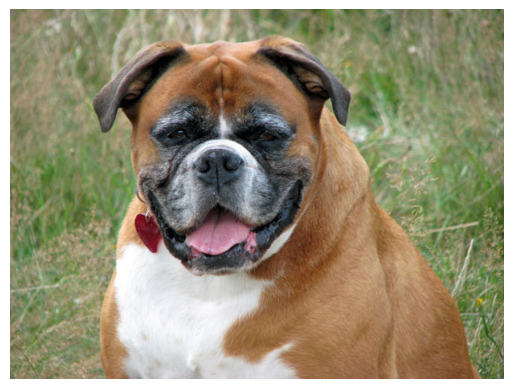

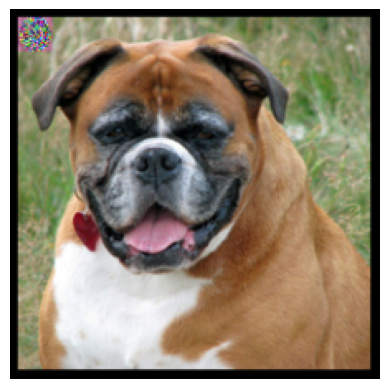

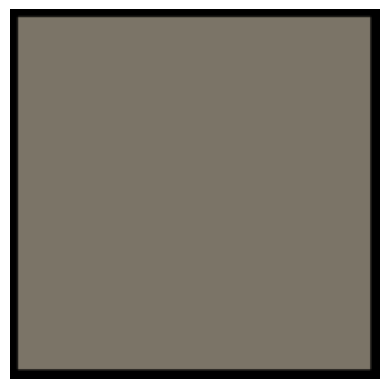

In [15]:
# Load from Hub
model = timm.create_model(
    'hf-hub:nateraw/resnet50-oxford-iiit-pet',
    pretrained=True
)

# Set model to eval mode for inference
model.eval()

# Create Transform
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))

# Get the labels from the model config
# edit: was "label_names", now "labels"
labels = model.pretrained_cfg['labels']
top_k = min(len(labels), 5)

# Use your own image file here...
#image = Image.open('saint_bernard.jpg').convert('RGB')
#target_label = torch.tensor([28])
image = Image.open('Boxer-dog.jpg').convert('RGB')
target_label = torch.tensor([8])
print(f"Original Label: {labels[target_label]}")

# Process PIL image with transforms and add a batch dimension
x = transform(image).unsqueeze(0)
x_init = x

# Get the adversarial patch
N, C, H, W = x.shape
patch_image = Image.open('adversarial_patch.png').convert('RGB')
patch_image = patch_image.resize((H//10, W//10))
patch = PILToTensor()(patch_image).unsqueeze(0)

# naively add patch to the image
N, C, HH, WW = patch.shape
x[:, :, :HH, :WW] += patch
y_pred = model(x)

#Apply softmax to get predicted probabilities for each class
probabilities = torch.nn.functional.softmax(y_pred[0], dim=0)

# Grab the values and indices of top 5 predicted classes
values, indices = torch.topk(probabilities, top_k)

# Prepare a nice dict of top k predictions
predictions = [
    {"label": labels[i], "score": v.item()}
    for i, v in zip(indices, values)
]
print(predictions)

# Display initial image
plt.imshow(image)
plt.axis('off')
plt.show()

# Display final image
final_image = inverse_transform(x.squeeze())
plt.imshow(final_image)
plt.axis('off')
plt.show()

# diff
diff_image = inverse_transform((x - x_init).squeeze())
plt.imshow(diff_image)
plt.axis('off')
plt.show()